<a href="https://colab.research.google.com/github/Nilkantg/SIH/blob/main/words_using_LSTM_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.filterwarnings("ignore")

In [ ]:
words_corpus = pd.read_csv('/content/preprocessed_data.xls')
words_corpus.head()

,Unnamed: 0,Feature-1,Feature-2,Feature-3,Feature-4,Feature-5,Feature-6,Feature-7,Feature-8,Feature-9,Feature-10,Word
0,0,1.150625,1.273182,-0.007743,0.069023,-0.037749,-0.054296,0.022695,0.034255,0.014332,0.034387,A LOT
1,1,1.771279,-1.039713,-0.032883,-0.093463,-0.039216,-0.010706,-0.017638,0.053692,0.013209,0.061865,A LOT
2,2,1.459590,-1.114549,-0.038475,-0.093194,-0.033570,-0.012623,-0.021878,0.054543,0.008132,0.051930,A LOT
3,3,1.654363,-1.163543,-0.050590,-0.086530,-0.056471,-0.009639,-0.015170,0.054248,0.005468,0.054465,A LOT
4,4,0.853788,1.048882,-0.029100,0.051494,-0.012735,-0.074172,0.021292,0.051028,0.015016,0.005590,A LOT


In [ ]:
words_corpus.drop("Unnamed: 0", inplace=True, axis=1)

In [ ]:
words_corpus.shape

(3104, 11)

In [ ]:
words_corpus.shape

(3104, 11)

In [ ]:
words_corpus["Word"].value_counts()

,count
Word,
I_ME_MINE_MY,52
SOME ONE,51
ANYTHING,49
BECOME,48
ALL,47
...,...
BRING,6
CONGRATULATIONS,6
NAME,3


In [ ]:
filtered_words_df = words_corpus[words_corpus["Word"].map(words_corpus["Word"].value_counts()) <= 20]

In [ ]:
filtered_words_df["Word"].nunique()

25

In [ ]:
filtered_words_df["Word"].unique()

array(['AGREE', 'ANGRY', 'BRING', 'COLLEGE_SCHOOL', 'CONGRATULATIONS',
       'DIFFERENCE', 'DO', 'FRIEND', 'FROM', 'HELLO_HI', 'HUNGRY',
       'MEDICINE', 'NAME', 'NUMBER', 'OLD_AGE', 'PHONE', 'SLOWER',
       'SPEAK', 'TALK', 'THINK', 'THIRSTY', 'TIRED', 'WHERE', 'CHAT',
       'WHO'], dtype=object)

In [ ]:
new_words_df = words_corpus[words_corpus["Word"].map(words_corpus["Word"].value_counts()) >= 20]

In [ ]:
new_words_df.head()

,Feature-1,Feature-2,Feature-3,Feature-4,Feature-5,Feature-6,Feature-7,Feature-8,Feature-9,Feature-10,Word
0,1.150625,1.273182,-0.007743,0.069023,-0.037749,-0.054296,0.022695,0.034255,0.014332,0.034387,A LOT
1,1.771279,-1.039713,-0.032883,-0.093463,-0.039216,-0.010706,-0.017638,0.053692,0.013209,0.061865,A LOT
2,1.459590,-1.114549,-0.038475,-0.093194,-0.033570,-0.012623,-0.021878,0.054543,0.008132,0.051930,A LOT
3,1.654363,-1.163543,-0.050590,-0.086530,-0.056471,-0.009639,-0.015170,0.054248,0.005468,0.054465,A LOT
4,0.853788,1.048882,-0.029100,0.051494,-0.012735,-0.074172,0.021292,0.051028,0.015016,0.005590,A LOT


In [ ]:
new_words_df.shape

(2882, 11)

In [ ]:
limited_words_df = new_words_df.groupby('Word').apply(lambda x: x.sample(n=20, random_state=42) if len(x) > 20 else x)

# Remove the multi-level index created by groupby and apply
limited_words_df = limited_words_df.reset_index(drop=True)

In [ ]:
limited_words_df.shape

(1820, 11)

In [ ]:
limited_words_df["Word"].value_counts()

,count
Word,
A LOT,20
SPEAK,20
SOMETHING,20
SOME ONE,20
SOME HOW,20
...,...
GOOD,20
GO,20
FREE,20


In [ ]:
limited_words_df["Word"].nunique()

91

In [ ]:
limited_words_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1820 entries, 0 to 1819
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Feature-1   1820 non-null   float64
 1   Feature-2   1820 non-null   float64
 2   Feature-3   1820 non-null   float64
 3   Feature-4   1820 non-null   float64
 4   Feature-5   1820 non-null   float64
 5   Feature-6   1820 non-null   float64
 6   Feature-7   1820 non-null   float64
 7   Feature-8   1820 non-null   float64
 8   Feature-9   1820 non-null   float64
 9   Feature-10  1820 non-null   float64
 10  Word        1820 non-null   object 
dtypes: float64(10), object(1)
memory usage: 156.5+ KB


In [ ]:
df = limited_words_df.copy()

In [ ]:
inputs = df.drop(['Word'], axis=1)
targets = df['Word']

In [ ]:
std_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

In [ ]:
scaled_inputs = std_scaler.fit_transform(inputs)

In [ ]:
scaled_inputs[1]

array([-0.66569805,  1.48072105, -0.12757284,  0.6378291 , -0.37635722,
        0.1777041 , -0.81292892,  0.24531453,  0.27539237,  0.13839179])

In [ ]:
scaled_inputs[1].shape

(10,)

In [ ]:
encoder = LabelEncoder()
target = encoder.fit_transform(targets)

In [ ]:
type(target)

numpy.ndarray

In [ ]:
inputs_train, inputs_test, target_train, target_test = train_test_split(scaled_inputs, target, test_size=0.1, random_state=369)

In [ ]:
inputs_train.shape

(1638, 10)

In [ ]:
def np_data(data):
  labels = np.array(data)

  return labels

In [ ]:
## Convertint pandas data to numpy
numpy_train_inputs = np_data(inputs_train)
numpy_train_target = np_data(target_train)
numpy_test_inputs = np_data(inputs_test)
numpy_test_target = np_data(target_test)

In [ ]:
# Train Dataset
train_dataset = TensorDataset(torch.from_numpy(numpy_train_inputs), torch.from_numpy(numpy_train_target))
# Test Dataset
test_dataset = TensorDataset(torch.from_numpy(numpy_test_inputs), torch.from_numpy(numpy_test_target))

In [ ]:
test_dataset.tensors[0].shape

torch.Size([182, 10])

In [ ]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# obtaining one batch of training data to check the shape
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample output size: ', sample_y.size())
print('Sample output: \n', sample_y)

Sample input size:  torch.Size([16, 10])
Sample input: 
 tensor([[ 2.0335,  0.1890,  0.2448, -0.7361,  0.9036, -0.4125, -0.0325,  0.7342,
          1.1028, -0.9364],
        [-0.3415, -0.9167,  0.2413, -0.8649,  0.7716, -0.0753, -0.9155, -2.4256,
         -1.4417, -0.0756],
        [-1.2616, -2.1307, -0.1287,  2.1558,  0.5597,  0.4947,  0.6627, -0.2103,
         -2.1849,  0.4933],
        [-0.4837,  0.1276, -0.5410, -1.2717, -0.5279, -0.6251,  1.0081, -0.1408,
          0.5381,  0.2036],
        [ 0.5861, -0.3867, -0.1316,  0.9118, -0.8746,  0.5202,  0.3976, -2.1706,
          1.3656, -1.6024],
        [ 0.0329,  0.4360,  1.1991,  1.1819, -0.2728, -0.3539,  0.2688, -0.4481,
         -0.3960, -0.7281],
        [-0.7033, -0.2860,  1.5238,  0.8087, -0.7391, -0.0955, -0.2011,  0.6591,
          0.0032,  2.1662],
        [ 1.4663,  1.3510,  0.1792,  1.0466,  0.0344,  0.1450,  1.2126, -2.4536,
         -2.1580,  0.5594],
        [ 0.5941,  0.9479, -0.0689,  0.8833,  0.5456, -1.6733, -0.4069,

**Building a Model**

In [ ]:

?nn.LSTM

In [ ]:
# batch_size = 32
# input_features = 64
# output_features = 114

In [ ]:
class LSTM_Model(nn.Module):
  def __init__(self, input_size, layers, hidden_dim, output_size):
    super(LSTM_Model, self).__init__()

    self.input_size = input_size
    self.layers = layers
    self.hidden_dim = hidden_dim
    self.output_size = output_size

    # lstm
    self.lstm = nn.LSTM(input_size = self.input_size,
                        hidden_size = self.hidden_dim,
                        num_layers = self.layers,
                        bias = True,
                        )

    # Fully connected layer | Output layer
    self.output_layer = nn.Linear(self.hidden_dim, self.output_size)

  def forward(self, inputs, hidden_inputs):

    # Ensure inputs and hidden states are of type float32
    inputs = torch.tensor(inputs, dtype=torch.float32)
    hidden_inputs = (
        torch.tensor(hidden_inputs[0], dtype=torch.float32),
        torch.tensor(hidden_inputs[1], dtype=torch.float32)
    )

    # LSTM expects input of shape (seq_length, batch_size, input_size)
    inputs = inputs.unsqueeze(0)  # Add sequence length dimension if needed

    # Pass through LSTM
    lstm_outputs, hidden_outputs = self.lstm(inputs, hidden_inputs)

    # Reshape LSTM outputs to (batch_size, hidden_dim)
    lstm_outputs = lstm_outputs.squeeze(0)  # Remove sequence length dimension

    # Pass through the fully connected layer
    outputs = self.output_layer(lstm_outputs)  # Shape: (batch_size, output_size)

    # outputs = F.softmax(outputs, dim=1)

    return outputs, hidden_outputs


In [ ]:
# sequence length should be no.of frames that are representing ne word, in this case I making sequence length to 28
# the frames are not consistent, so I will be using augmentation method (creating the data by applying simple transformations)
# input_size i.i., no.of features(columns in simple terms) is 64
# hidden_inputs shape will be (sequence_length, batch_size, n_layers)
# inputs shape will be (sequence_length, batch_size, input_size)

In [ ]:
input_size = 10    ## input features
hidden_layers = 3
hidden_dim = 1024
output_size = limited_words_df["Word"].nunique()
seq_length = 20

In [ ]:
# ## demo
h0 = torch.zeros(hidden_layers, batch_size, hidden_dim)
c0 = torch.zeros(hidden_layers, batch_size, hidden_dim)
h = (h0, c0)
inputs = sample_x

model = LSTM_Model(input_size, hidden_layers, hidden_dim, output_size)
outputs, hidden_outputs = model(inputs, h)

In [ ]:
sample_x.shape[0]

16

In [ ]:
outputs.shape

torch.Size([16, 91])

In [ ]:
sample_y.shape

torch.Size([16])

In [ ]:
## model building
model = LSTM_Model(input_size, hidden_layers, hidden_dim, output_size)
## optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
## loss function
loss_fun = nn.CrossEntropyLoss()
# loss_fun = nn.MSELoss()

In [ ]:
def training_model(nepochs, train_loader, model, optimizer, loss_fun):

  nepochs = nepochs

  training_loss = np.zeros(nepochs)
  training_acc = np.zeros(nepochs)

  for epoch in range(nepochs):

    batch_loss = []
    batch_acc = []

    for train_x, train_y in train_loader:

      batch_size = train_x.shape[0]
      ht = torch.zeros(hidden_layers, batch_size, hidden_dim)
      ct = torch.zeros(hidden_layers, batch_size, hidden_dim)
      hidden_inputs = (ht, ct)

      outputs, hidden_outputs = model(train_x, hidden_inputs)

      loss = loss_fun(outputs, train_y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      ## appending loss to the batch_loss
      batch_loss.append(loss.item())

      matches = torch.argmax(outputs, axis=1) == train_y
      matchesNumeric = matches.float()
      accuracyPct = 100 * torch.mean(matchesNumeric)

      ## appending accuracy to the batch_acc
      batch_acc.append(accuracyPct)

    if epoch % 5 == 0:
      print(f"epoch {epoch} loss: {np.mean(batch_loss)}, acc: {np.mean(batch_acc)}")

    training_loss[epoch] = np.mean(batch_loss)
    training_acc[epoch] = np.mean(batch_acc)

  return training_loss, training_acc


In [ ]:
training_loss, training_acc = training_model(20, train_loader, model, optimizer, loss_fun)

epoch 0 loss: 4.161276210858984, acc: 5.198220252990723
epoch 5 loss: 1.492916640726108, acc: 54.53074264526367
epoch 10 loss: 0.6283592076845539, acc: 79.69255065917969
epoch 15 loss: 0.32685618377426295, acc: 89.68446350097656
epoch 20 loss: 0.17670206725597382, acc: 94.37702178955078


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Text(0.5, 1.0, 'Training Accuracy')

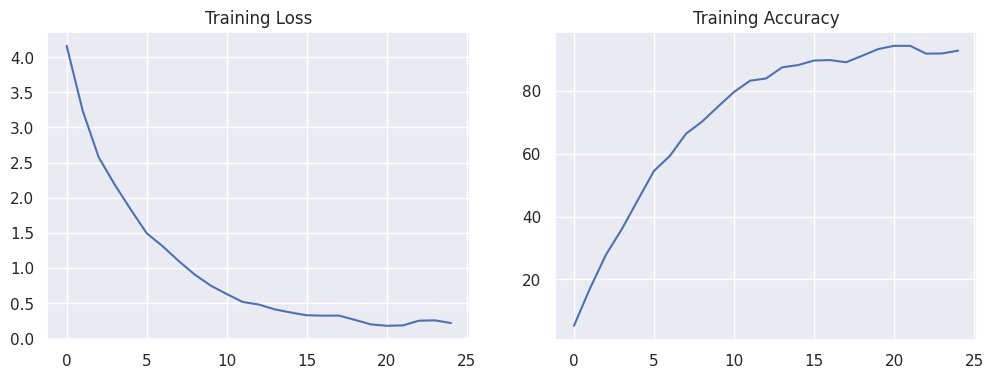

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

ax1.plot(training_loss)
ax2.plot(training_acc)

ax1.set_title("Training Loss")
ax2.set_title("Training Accuracy")

In [ ]:
with torch.no_grad():
    batch_test_acc = []
    batch_test_loss = []

    for tex_x, test_y in test_loader:
        batch_size = tex_x.shape[0]
        ht = torch.zeros(hidden_layers, batch_size, hidden_dim)
        ct = torch.zeros(hidden_layers, batch_size, hidden_dim)
        hidden_inputs = (ht, ct)

        outputs, hidden_outputs = model(tex_x, hidden_inputs)

        loss = loss_fun(outputs, test_y)

        batch_test_loss.append(loss.item())

        matches = torch.argmax(outputs, axis=1) == test_y
        matchesNumeric = matches.float()
        accuracyPct = 100 * torch.mean(matchesNumeric)
        batch_test_acc.append(accuracyPct)

    test_loss = np.mean(batch_test_loss)
    test_acc = np.mean(batch_test_acc)

    print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")



Test Loss: 2.0870465685923896, Test Accuracy: 64.2361068725586


In [ ]:
# import pickle

# pickle.dump(model, open('words_model.pkl', 'wb'))
# pickle.dump(std_scaler, open('words_std_scaler.pkl', 'wb'))
# pickle.dump(encoder, open('words_encoder.pkl', 'wb'))

In [ ]:
# original_labels = encoder.inverse_transform(targets)
# original_labels